In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model

from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
# dataset is taken from kaggle https://www.kaggle.com/uciml/sms-spam-collection-dataset
df = pd.read_csv('./spam.csv')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# convert labels to binary numbers
df['class'] = df['v1'].map({'ham': 0, 'spam': 1}) 
Y = df['class'].values

In [5]:
# Split training set and testing set
df_train, df_test, Ytrain, Ytest = train_test_split(df['v2'], Y, test_size=0.2)

In [6]:
# Convert string into vector of integers
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_SIZE = 160

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

# pad the sequences so each vector in the matrix has same length
data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_SIZE)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_SIZE)

print('Shape of data train tensor:', data_train.shape)
print('Shape of data test tensor:', data_test.shape)

Shape of data train tensor: (4457, 160)
Shape of data test tensor: (1115, 160)


## Create RNN model

In [7]:
# Create the model

x = Input(shape=(data_train.shape[1],))
y = Embedding(len(tokenizer.word_index) + 1, 20)(x)
y = LSTM(15, return_sequences=True)(y)
y = GlobalMaxPooling1D()(y)
y = Dense(1, activation='sigmoid')(y) 

model = Model(inputs=x, outputs=y)


## Compile and fit RNN model

In [8]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

fitted_model = model.fit(
  x=data_train,
  y=Ytrain,
  epochs=10,
  validation_split=0.2,
)

Train on 3565 samples, validate on 892 samples
Epoch 1/10
3565/3565 [==============================] - 27s 8ms/sample - loss: 0.4814 - accuracy: 0.8589 - val_loss: 0.3857 - val_accuracy: 0.8565
Epoch 2/10
3565/3565 [==============================] - 23s 6ms/sample - loss: 0.2683 - accuracy: 0.8684 - val_loss: 0.2421 - val_accuracy: 0.8565
Epoch 3/10
3565/3565 [==============================] - 24s 7ms/sample - loss: 0.1660 - accuracy: 0.9307 - val_loss: 0.1741 - val_accuracy: 0.9462
Epoch 4/10
3565/3565 [==============================] - 24s 7ms/sample - loss: 0.1108 - accuracy: 0.9891 - val_loss: 0.1347 - val_accuracy: 0.9697
Epoch 5/10
3565/3565 [==============================] - 23s 6ms/sample - loss: 0.0733 - accuracy: 0.9944 - val_loss: 0.1166 - val_accuracy: 0.9697
Epoch 6/10
3565/3565 [==============================] - 22s 6ms/sample - loss: 0.0522 - accuracy: 0.9952 - val_loss: 0.1102 - val_accuracy: 0.9731
Epoch 7/10
3565/3565 [==============================] - 23s 6ms/sample 

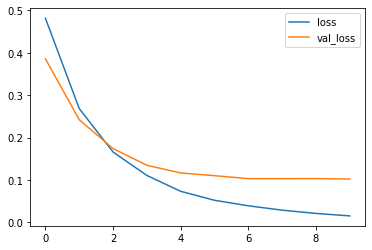

In [9]:
# Plot loss vs iteration
plt.plot(fitted_model.history['loss'], label='loss')
plt.plot(fitted_model.history['val_loss'], label='val_loss')
plt.legend()

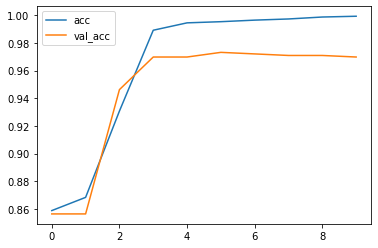

In [10]:
# Plot accuracy vs iteration
plt.plot(fitted_model.history['accuracy'], label='acc')
plt.plot(fitted_model.history['val_accuracy'], label='val_acc')
plt.legend()

## Model prediction and evaluation

In [11]:
Ypreds = (model.predict(data_test) > 0.5).astype("int32")

In [12]:
print('Model Accuracy score:', metrics.accuracy_score(Ytest, Ypreds))

Model Accuracy score: 0.9766816143497757


Text(0.5, 1.0, 'Normalized Confusion Matrix of test dataset')

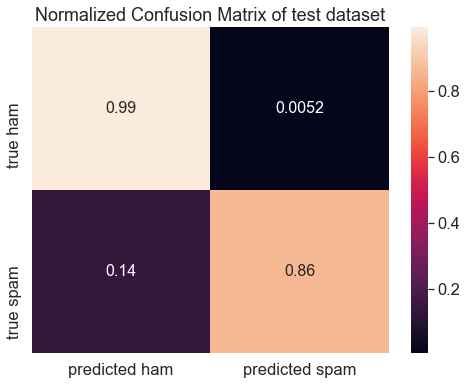

In [13]:
cm= np.array(metrics.confusion_matrix(Ytest, Ypreds))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, ['true ham', 'true spam'], ['predicted ham', 'predicted spam'])
plt.figure(figsize=(8,6))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.title('Normalized Confusion Matrix of test dataset')